In [6]:
# from osim.env import ProstheticsEnv
# import opensim
from pyquaternion import Quaternion
import matplotlib.pyplot as plt
import numpy as np
import math as m
from bvh import Bvh
import matplotlib
import gym
import random as r
r.seed()

In [91]:
class ReferenceMotion:
    def __init__(self, filename, period, offset):
        with open(filename) as f:
            mocap = Bvh(f.read())
        
        self.mocap = mocap
        self.period = period
        self.offset = offset

        joints = {}
        joints['knee_l'] = mocap.frames_joint_channels('LeftLeg',['Xrotation'])
        joints['knee_r'] = mocap.frames_joint_channels('RightLeg',['Xrotation'])
#         joints['ankle_l'] = mocap.frames_joint_channels('LeftFoot',['Xrotation'])
        joints['hip_l'] = mocap.frames_joint_channels('LeftUpLeg',['Xrotation', 'Yrotation', 'Zrotation'])
        joints['hip_r'] = mocap.frames_joint_channels('RightUpLeg',['Xrotation', 'Yrotation', 'Zrotation'])

        self.joints = {k: [[m.radians(-e) for e in l] for l in v][self.offset:self.offset+self.period] for (k, v) in joints.items() }
        
        self.joints['phase'] = [(i) / self.period for i in range(self.period)]
        
    def __getitem__(self, frame):
        return {k: v[frame] for (k, v) in self.joints.items()}

    def __iter__(self):
        for frame in range(self.period):
            yield {k: v[frame] for (k, v) in self.joints.items()}
    
    def __len__(self):
        return self.period

In [92]:
class ReferenceMotionWrapper(gym.Wrapper):
    def __init__(self, env, motion_file, period=89, offset=31, omega=1., rsi=False):
        super(ReferenceMotionWrapper, self).__init__(env)

        env_obs_shape = env.observation_space.shape[0]
        self.observation_space = gym.spaces.Box(low=np.zeros([env_obs_shape+1,]), high=np.zeros([env_obs_shape+1,]), dtype=np.float32)       
        
        self.motion = ReferenceMotion(motion_file, period=period, offset=offset)
        self.frame = 0
        self.omega = omega
        self.rsi = rsi

    def step(self, action, **kwargs):
        observation, reward, done, info = self.env.step(action, **kwargs)
        observation, reward = self.observation(observation), self.reward(reward)
        
        idx = np.argmax([self.calculate_similarity(frame, self.env.get_state_desc()['joint_pos']) for frame in self.motion])
        self.frame = (idx + 1) % len(self.motion) # set the target frame to the nearest state + 1, might want to rate limit this at some point
        print([self.calculate_similarity(frame, self.env.get_state_desc()['joint_pos']) for frame in self.motion])
        return observation, reward, done, info

    def reset(self, project=True, **kwargs):
        observation = self.env.reset(project, **kwargs)
        
        if self.rsi:
            self.frame = r.randint(0,len(self.motion)-1)
            self.set_state_desc(self.motion[self.frame])
            self.env.osim_model.model.equilibrateMuscles(self.env.osim_model.get_state())
            self.env.osim_model.state_desc_istep = None

            if project:
                observation = self.env.get_observation()
            else:
                observation = self.env.get_state_desc()
    
        return self.observation(observation)

    def observation(self, observation):
        if isinstance(observation, dict):
            observation['phase'] = self.frame / len(self.motion)
        elif isinstance(observation, list):
            observation += [self.frame / len(self.motion)]

        return observation

    def reward(self, reward):
        reward += self.calculate_similarity(self.motion[self.frame], self.env.get_state_desc()['joint_pos']) * self.omega
        return reward

    def calculate_similarity(self, ref_state_desc, curr_state_desc):
        ref = set(ref_state_desc)
        curr = set(curr_state_desc)
        return np.mean([np.mean(np.cos(np.subtract(ref_state_desc[name], curr_state_desc[name]))) for name in ref.intersection(curr)])

    def set_state_desc(self, state_desc):
        state = self.env.osim_model.get_state()

        for joint in self.env.osim_model.model.getJointSet():
            name = joint.getName()
            if name in state_desc.keys():
                [joint.get_coordinates(i).setValue(state, state_desc[name][i]) for i in range(joint.numCoordinates())]

        self.env.osim_model.set_state(state)

In [ ]:
env = ProstheticsEnv(visualize=True)
wrapped_env = ReferenceMotionWrapper(env, omega=1., motion_file='mocap_data/running_guy_keyframes.bvh', period=6, offset=0)
observation = wrapped_env.reset(project=False)

In [ ]:
for j in range(1):
    observation, reward, done, info = wrapped_env.step(wrapped_env.action_space.sample(), project=False)
    print(wrapped_env.frame, wrapped_env.reward(0.))
    if done: break

# Let's try this in roboschool first, at least that way I can get results more quickly

In [2]:
import roboschool
import gym

In [3]:
env = gym.make('RoboschoolHumanoid-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: Environment '<class 'roboschool.gym_mujoco_walkers.RoboschoolHumanoid'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.


In [ ]:
env.reset()

env.render()
env.step(env.action_space.sample())

# Character Retargeting

Works by just modifying the translations of a given skeleton! It doesn't do anything with the rotations. So as long as the coordinate frames of my mocap data isn't defined stupidly (which it is from memory) I can take the difference in angle and angular speed between my mocap frames and the agent as the reward - done!

Assuming I can get the same info from the osim model... I feel like I might be able to though, with a bit of bother

lwaist
[[ 0.98949771 -0.14134945  0.03024265]
 [ 0.14125212  0.98995924  0.00534178]
 [-0.03069405 -0.00101384  0.99952831]] (-0.001014314044950608, 0.0306988692458321, 0.14179336148819954)
pelvis
[[ 0.98961076 -0.13851554  0.03852253]
 [ 0.14127236  0.98659745 -0.08165529]
 [-0.0266957   0.08624913  0.99591587]] (0.08638728254982476, 0.02669887644658496, 0.14179742017413796)
right_thigh
[[ 0.99368498 -0.09179042 -0.06453428]
 [ 0.08853724  0.99473613 -0.05158679]
 [ 0.06892975  0.04554733  0.99658122]] (0.04567180280593196, -0.0689844540475414, 0.08886524679310961)
right_shin
[[ 0.99119654 -0.09179042 -0.09541453]
 [ 0.08688964  0.99473613 -0.05431604]
 [ 0.09989797  0.04554733  0.99395464]] (0.04579232444602329, -0.100064876438649, 0.08743784475960822)
right_foot
[[ 0.99119654 -0.09179042 -0.09541453]
 [ 0.08688964  0.99473613 -0.05431604]
 [ 0.09989797  0.04554733  0.99395464]] (0.04579232444602329, -0.100064876438649, 0.08743784475960822)
left_thigh
[[ 0.98264338 -0.16988206 -0.074

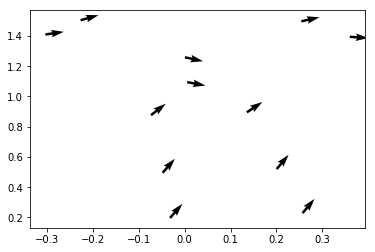

In [22]:
robot = env.env.mjcf[0]

robot.root_part.pose().quatertion()


plt.figure()

for part in filter(lambda x: 'link' not in x.name, robot.parts):
    print(part.name)
    pose = part.pose()
    
    q = part.pose().quatertion()
    q = Quaternion(q[3],q[0],q[1],q[2])
    R = q.rotation_matrix
    
    print(R, part.pose().rpy())
    
    # I want the x unit vector in the y z plane, that's the 2nd and 3rd elements of the first column of the rotation matrix
    
    plt.quiver(pose.xyz()[1], pose.xyz()[2], R[1,0], R[2,0], units='width')
    
plt.show()

In [146]:
rotation = np.eye(3)
transformation = np.eye(4)
q8d = Quaternion(matrix=rotation) # Using 3x3 rotation matrix
q8d = Quaternion(matrix=transformation) # Using 4x4 transformation matrix

q_in = part.pose().quatertion()
q = Quaternion(q_in[3],q_in[0],q_in[1],q_in[2])

print(q)

q.rotation_matrix

0.997 -0.001i +0.000j -0.081k


array([[ 9.86994234e-01,  1.60754577e-01,  5.90363268e-04],
       [-1.60755534e-01,  9.86991420e-01,  2.36552744e-03],
       [-2.02414117e-04, -2.42966610e-03,  9.99997028e-01]])

In [1]:
for j in env.env.ordered_joints:
    print (j.name, j.reset_current_position())

NameError: name 'env' is not defined